In [1]:
%load_ext autotime
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from glob import glob
from shapely.geometry import LineString, Point
import folium
import matplotlib.pyplot as plt
import pytz
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)
import SDS_slope

In [39]:
df = pd.read_csv("data/nzd0563/transect_time_series.csv")
df.index = pd.to_datetime(df.dates)
df.drop(columns=["dates", "satname"], inplace=True)
df

,nzd0563-0000,nzd0563-0001,nzd0563-0002
dates,,,
1999-08-12 21:53:08+00:00,167.37,435.88,173.36
1999-08-21 21:46:56+00:00,169.07,435.90,174.25
1999-08-28 21:53:11+00:00,170.95,435.14,176.64
1999-09-22 21:47:00+00:00,192.66,436.61,192.60
1999-09-29 21:53:16+00:00,181.07,435.01,170.19
...,...,...,...
2024-10-20 21:54:09+00:00,188.32,435.46,163.49
2024-10-27 22:00:15+00:00,191.17,438.30,185.31
2024-11-04 22:00:21+00:00,176.08,434.53,159.20


In [40]:
tides = pd.read_csv("data/nzd0563/tides.csv")
tides.dates = pd.to_datetime(tides.dates)
tides.set_index("dates", inplace=True)
tides

,tide
dates,
1999-08-12 21:50:00+00:00,-0.11
1999-08-21 21:50:00+00:00,-0.23
1999-08-28 21:50:00+00:00,0.03
1999-09-22 21:50:00+00:00,-0.54
1999-09-29 21:50:00+00:00,0.83
...,...
2024-10-20 21:50:00+00:00,0.67
2024-10-27 22:00:00+00:00,-0.27
2024-11-04 22:00:00+00:00,0.37


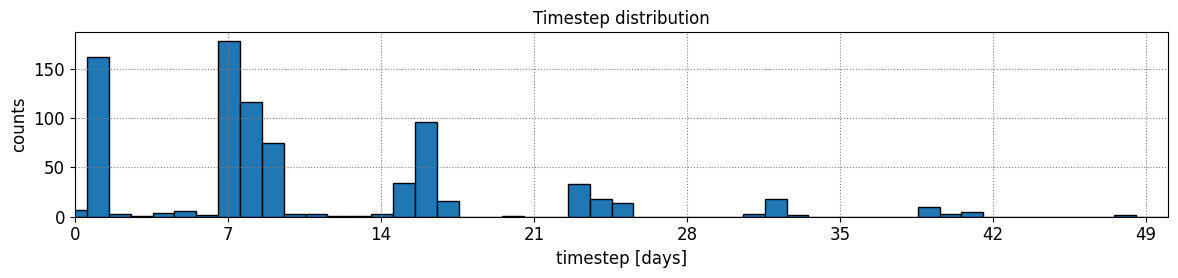

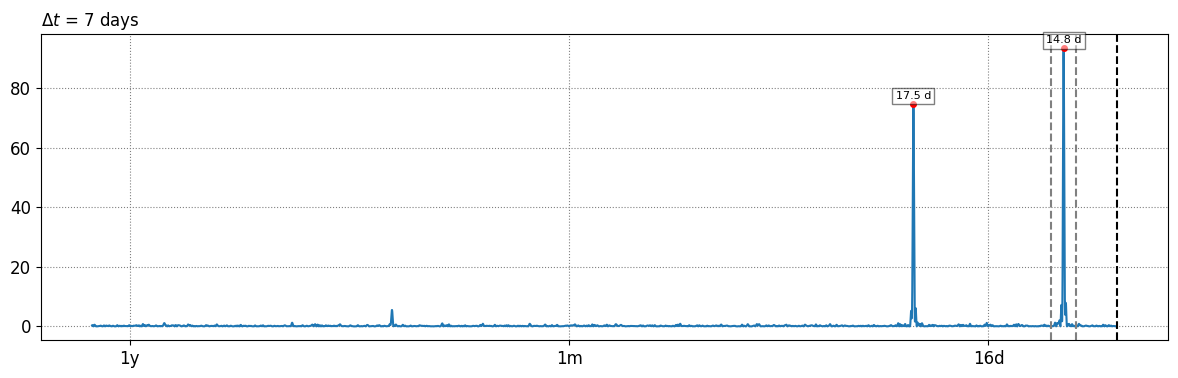

In [42]:
# slope estimation settings
days_in_year = 365.2425
seconds_in_day = 24*3600
settings_slope = {'slope_min':        0.01,                  # minimum slope to trial
                  'slope_max':        0.2,                    # maximum slope to trial
                  'delta_slope':      0.005,                  # slope increment
                  'date_range':       [1999,2020],            # range of dates over which to perform the analysis
                  'n_days':           8,                      # sampling period [days]
                  'n0':               50,                     # parameter for Nyquist criterium in Lomb-Scargle transforms
                  'freqs_cutoff':     1./(seconds_in_day*30), # 1 month frequency
                  'delta_f':          100*1e-10,              # deltaf for identifying peak tidal frequency band
                  'prc_conf':         0.05,                   # percentage above minimum to define confidence bands in energy curve
                  }
settings_slope['date_range'] = [pytz.utc.localize(datetime(settings_slope['date_range'][0],5,1)),
                                pytz.utc.localize(datetime(settings_slope['date_range'][1],1,1))]
beach_slopes = SDS_slope.range_slopes(settings_slope['slope_min'], settings_slope['slope_max'], settings_slope['delta_slope'])

t = np.array([_.timestamp() for _ in df.index]).astype('float64')
delta_t = np.diff(t)
fig, ax = plt.subplots(1,1,figsize=(12,3), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
bins = np.arange(np.min(delta_t)/seconds_in_day, np.max(delta_t)/seconds_in_day+1,1)-0.5
ax.hist(delta_t/seconds_in_day, bins=bins, ec='k', width=1);
ax.set(xlabel='timestep [days]', ylabel='counts',
       xticks=7*np.arange(0,20),
       xlim=[0,50], title='Timestep distribution');

# find tidal peak frequency (can choose 7 or 8 in this case)
settings_slope['n_days'] = 7
settings_slope['freqs_max'] = SDS_slope.find_tide_peak(df.index,tides.tide,settings_slope)

In [43]:
beach_slopes

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  ])

In [44]:
assert all(pd.to_datetime(df.index).round("10min") == tides.index)

Beach slope at transect nzd0563-0000: 0.200
Beach slope at transect nzd0563-0001: 0.050
Beach slope at transect nzd0563-0002: 0.070


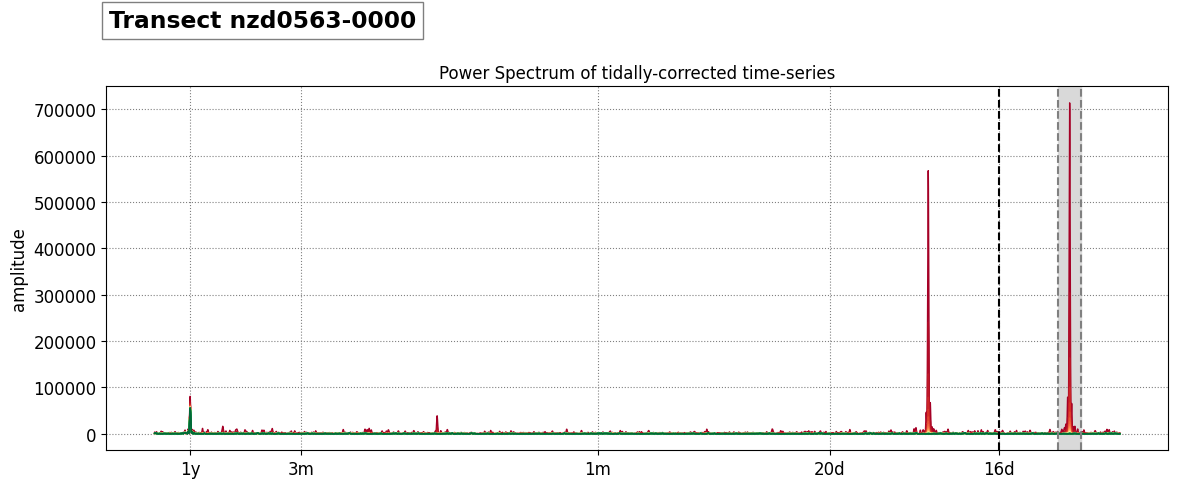

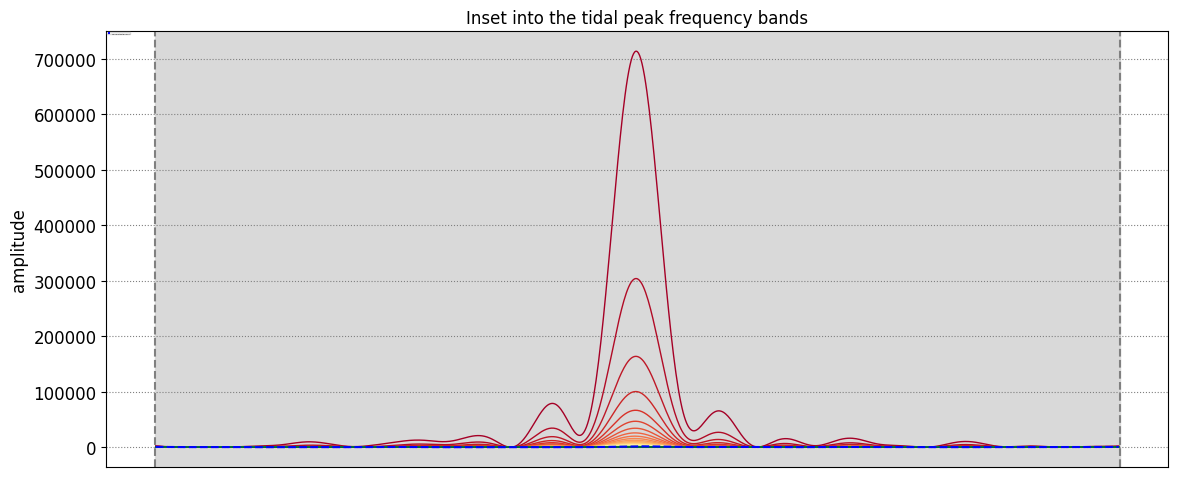

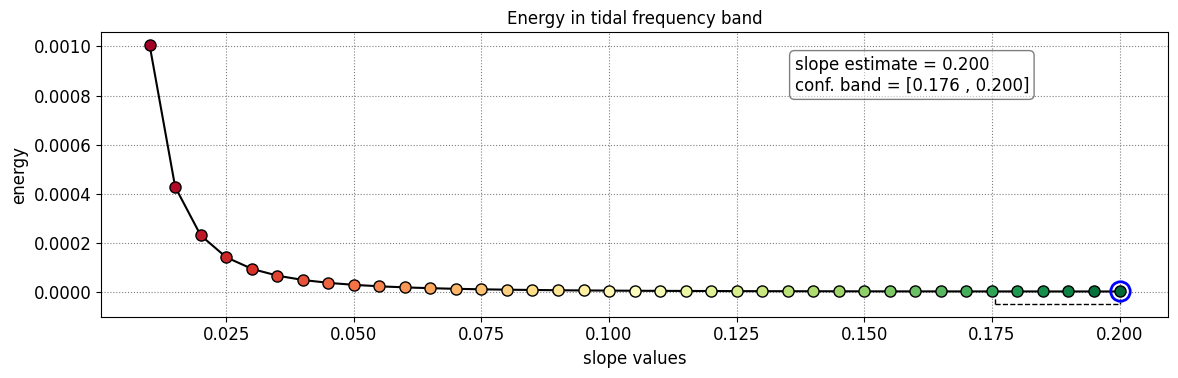

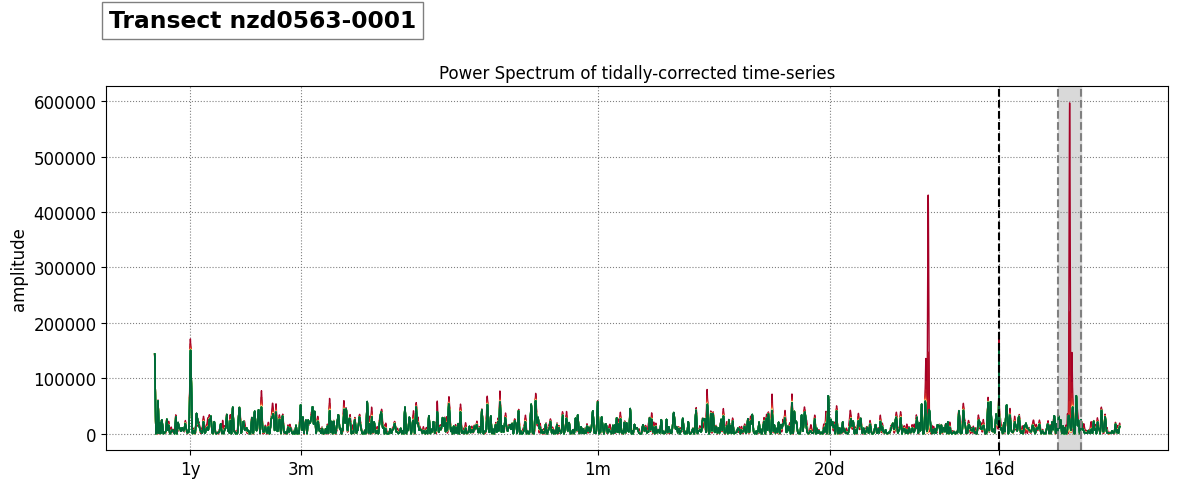

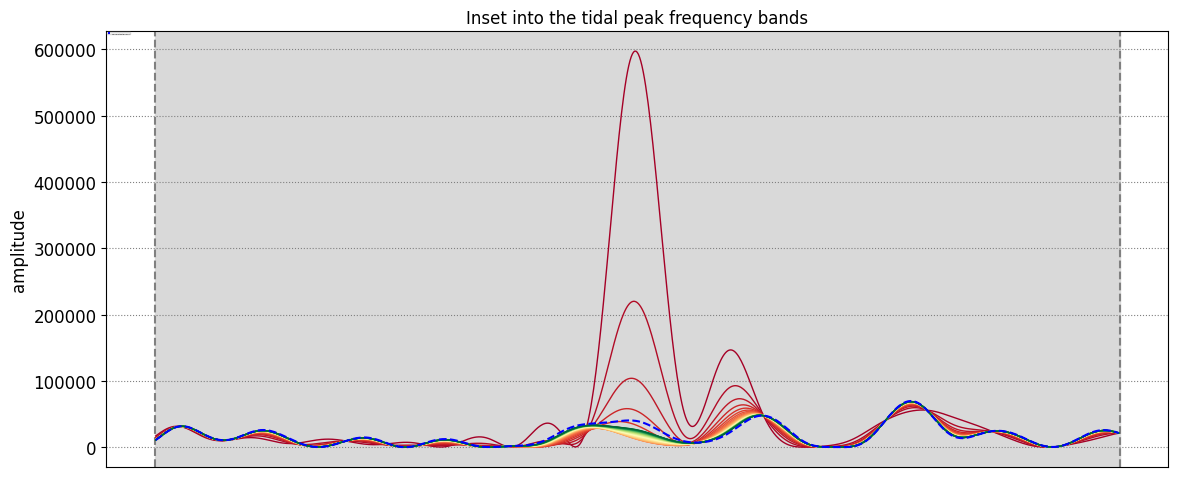

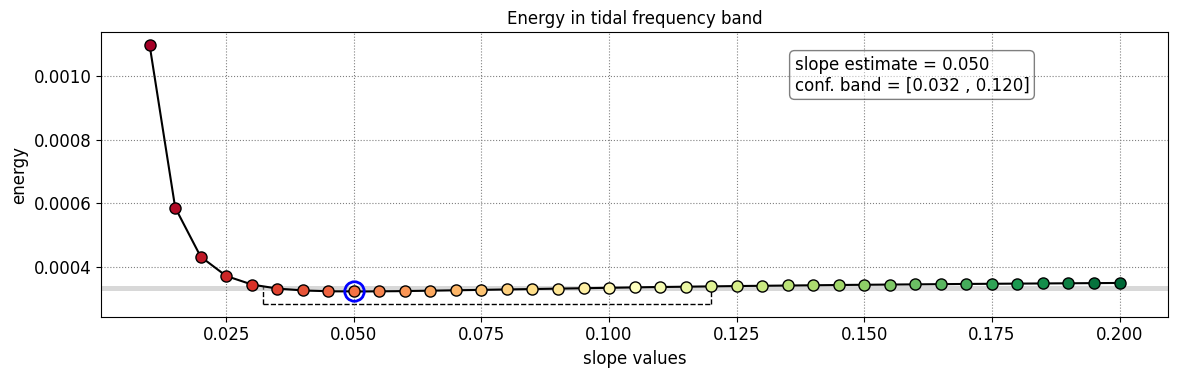

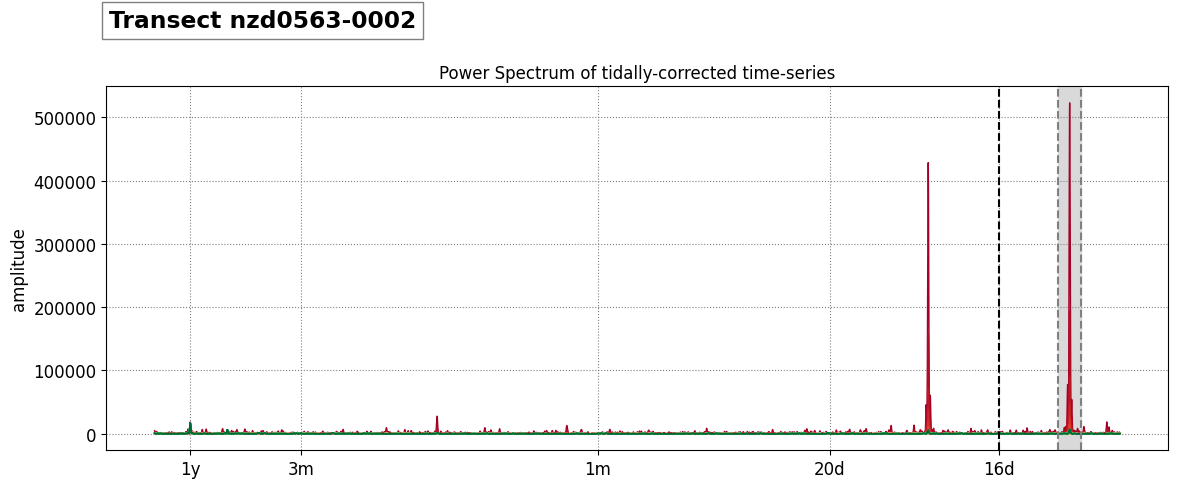

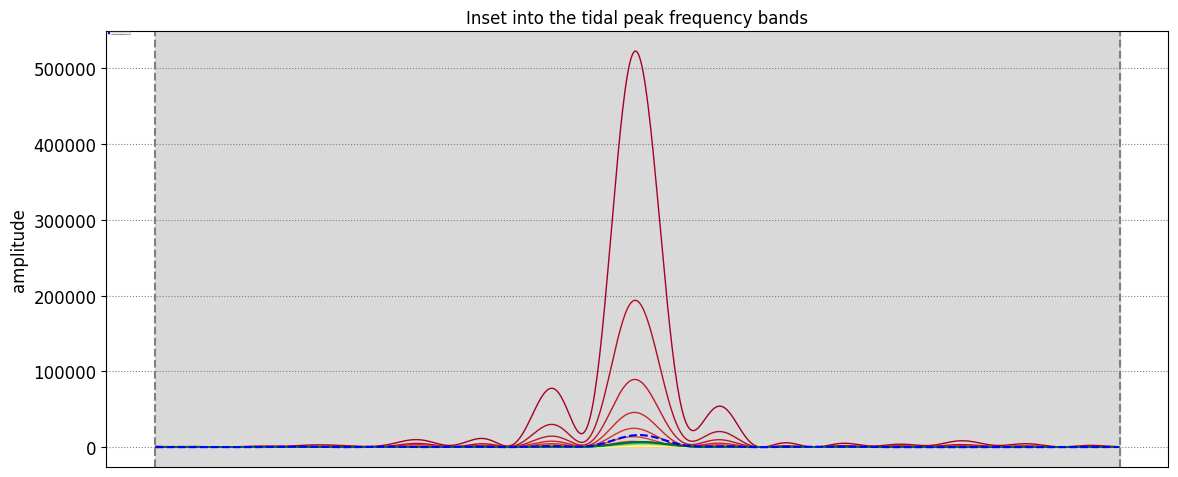

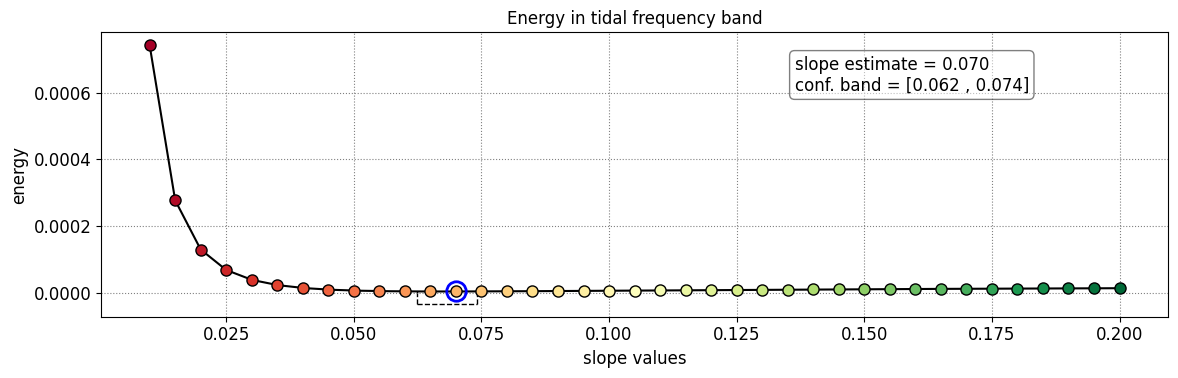

In [45]:
# estimate beach-face slopes along the transects
slope_est, cis = dict([]), dict([])
for key in df.keys():
    # remove NaNs
    idx_nan = np.isnan(df[key])
    dates = [df.index[_] for _ in np.where(~idx_nan)[0]]
    tide = tides.tide.to_numpy()[~idx_nan]
    composite = df[key][~idx_nan]
    # apply tidal correction
    tsall = SDS_slope.tide_correct(composite,tide,beach_slopes)
    title = 'Transect %s'%key
    SDS_slope.plot_spectrum_all(dates,composite,tsall,settings_slope, title)
    slope_est[key],cis[key] = SDS_slope.integrate_power_spectrum(dates,tsall,settings_slope)
    print('Beach slope at transect %s: %.3f'%(key, slope_est[key]))

In [46]:
slope_est, cis

({'nzd0563-0000': 0.2, 'nzd0563-0001': 0.05, 'nzd0563-0002': 0.07},
 {'nzd0563-0000': [0.1756, 0.2],
  'nzd0563-0001': [0.0323, 0.12],
  'nzd0563-0002': [0.0624, 0.0742]})

In [21]:
transects = gpd.read_file("transects_extended.geojson").set_index("id")
transects

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,r2_score,mae,mse,rmse,intercept,geometry
id,,,,,,,,,,,,,,,,
aus0001-0000,aus0001,104.347648,0.000000,0.000000,0.085,0.0545,0.2000,-1.456305,654.0,342.0,0.131951,28.721214,1321.059410,36.346381,179.407277,"LINESTRING (153.26555 -24.7007, 153.26938 -24...."
aus0001-0001,aus0001,93.495734,98.408334,0.002935,0.050,0.0387,0.0640,-0.833581,654.0,473.0,0.052783,26.029482,1092.336862,33.050520,210.629160,"LINESTRING (153.26525 -24.7019, 153.2692 -24.7..."
aus0001-0002,aus0001,82.069341,198.408334,0.005918,0.050,0.0428,0.0647,-0.282209,654.0,491.0,0.008220,22.896464,838.997233,28.965449,200.166307,"LINESTRING (153.26539 -24.70316, 153.26931 -24..."
aus0001-0003,aus0001,81.192757,298.402523,0.008900,0.055,0.0480,0.0659,0.089340,654.0,502.0,0.000987,20.770475,691.179232,26.290288,185.295473,"LINESTRING (153.26555 -24.70408, 153.26945 -24..."
aus0001-0004,aus0001,81.065473,398.402523,0.011882,0.075,0.0614,0.0922,0.361437,654.0,508.0,0.017461,19.528839,637.676213,25.252252,169.027861,"LINESTRING (153.2657 -24.70497, 153.26961 -24...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nzd0562-0017,nzd0562,NaN,NaN,NaN,0.100,NaN,NaN,0.005730,583.0,405.0,0.000014,8.118279,126.880731,11.264135,209.805326,"LINESTRING (174.9093 -36.86951, 174.91331 -36...."
nzd0562-0018,nzd0562,NaN,NaN,NaN,0.100,NaN,NaN,0.424099,583.0,365.0,0.045716,9.717575,202.294073,14.223012,208.659953,"LINESTRING (174.90891 -36.86889, 174.91293 -36..."
nzd0563-0000,nzd0563,NaN,NaN,NaN,0.100,NaN,NaN,-0.277580,770.0,683.0,0.018699,13.191099,225.924210,15.030775,182.873838,"LINESTRING (176.9374 -39.3345, 176.938 -39.33807)"


In [47]:
transects.beach_slope.update(slope_est)
transects.cil.update({k: v[0] for k,v in cis.items()})
transects.ciu.update({k: v[1] for k,v in cis.items()})
transects[transects.index.isin(slope_est.keys())]

/tmp/ipykernel_980372/4139878928.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transects.beach_slope.update(slope_est)
/tmp/ipykernel_980372/4139878928.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,r2_score,mae,mse,rmse,intercept,geometry
id,,,,,,,,,,,,,,,,
nzd0563-0000,nzd0563,NaN,NaN,NaN,0.20,0.1756,0.2000,-0.277580,770.0,683.0,0.018699,13.191099,225.924210,15.030775,182.873838,"LINESTRING (176.9374 -39.3345, 176.938 -39.33807)"
nzd0563-0001,nzd0563,NaN,NaN,NaN,0.05,0.0323,0.1200,-0.062965,770.0,614.0,0.007388,4.436646,30.759972,5.546167,437.106630,"LINESTRING (176.93648 -39.33459, 176.93708 -39..."
nzd0563-0002,nzd0563,NaN,NaN,NaN,0.07,0.0624,0.0742,-0.254745,770.0,632.0,0.024568,9.215089,146.102315,12.087279,172.828009,"LINESTRING (176.93431 -39.33569, 176.93792 -39..."


In [50]:
transects.to_file("transects_extended.geojson")